In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import time
from tqdm import tqdm
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torchvision import transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


from typing import Optional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/DL_Term

/content/drive/MyDrive/Colab Notebooks/DL_Term


In [ ]:
!ls

archive.zip  Data  ResGAN_Cross.ipynb  ResGAN.ipynb  ResNet


In [ ]:
!unzip archive.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train = ImageFolder('./seg_train/seg_train', transform=transform)
test = ImageFolder('./seg_test/seg_test', transform=transform)
pred = ImageFolder('./seg_pred/', transform=transform)

In [ ]:
print(len(train), len(test), len(pred))

14034 3000 7301


# ResNet

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## 18-layer

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

net18 = ResNet18()

print("ResNet-18:\n", net18)

ResNet-18:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stri

## 34-layer

In [ ]:
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

net34 = ResNet34()

print("\nResNet-34:\n", net34)


ResNet-34:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

## 50-layer

In [ ]:
def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

net50 = ResNet50()

print("\nResNet-50:\n", net50)


ResNet-50:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1

# Train

In [ ]:
batch_size = 128

train_dl = DataLoader(train, batch_size, shuffle=True)
test_dl = DataLoader(test, batch_size)
pred_dl = DataLoader(pred, batch_size)

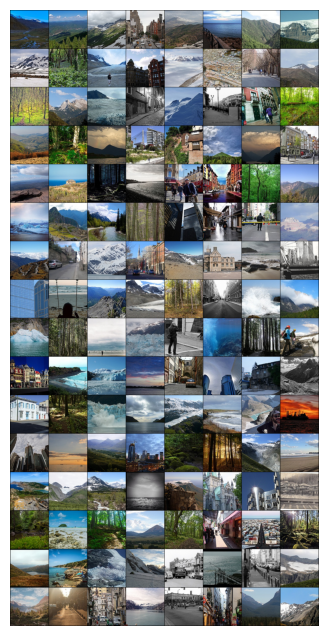

In [ ]:
for images, _ in train_dl:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 18-layer

In [ ]:
model18 = net18.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model18.parameters(), lr=0.001)

train_losses18 = []
val_losses18 = []

In [ ]:
# train-18-layer
start_time = time.time()
for epoch in range(10):
    model18.train()
    train_loss, correct, count = 0, 0, 0
    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model18(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(output, 1)
        count += labels.size(0)
        correct += preds.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_dl)
    train_losses18.append(avg_train_loss)
    train_accuracy = correct / count

    print(f"Epoch: {epoch+1} \tTrain accuracy: {train_accuracy:.4f} \tTrain Loss: {avg_train_loss:.4f}")

    # valid
    model18.eval()
    valid_loss, correct, count = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc="Validation", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            output = model18(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()

            _, preds = torch.max(output, 1)
            count += labels.size(0)
            correct += (preds == labels).sum().item()

    average_valid_loss = valid_loss / len(test_dl)
    val_losses18.append(average_valid_loss)
    val_accuracy = correct / count
    print(f"Validation accuracy: {val_accuracy:.4f}, Validation Loss: {average_valid_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total Training Time {elapsed_time:.2f} seconds")


Epoch 1: 100%|██████████| 110/110 [00:43<00:00,  2.51batch/s]


Epoch: 1 	Train accuracy: 0.6467 	Train Loss: 0.9250


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.90batch/s]


Validation accuracy: 0.6003, Validation Loss: 1.0579


Epoch 2: 100%|██████████| 110/110 [00:43<00:00,  2.54batch/s]


Epoch: 2 	Train accuracy: 0.7810 	Train Loss: 0.5998


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.93batch/s]


Validation accuracy: 0.3900, Validation Loss: 2.5372


Epoch 3: 100%|██████████| 110/110 [00:43<00:00,  2.52batch/s]


Epoch: 3 	Train accuracy: 0.8068 	Train Loss: 0.5271


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.88batch/s]


Validation accuracy: 0.7110, Validation Loss: 0.9178


Epoch 4: 100%|██████████| 110/110 [00:43<00:00,  2.51batch/s]


Epoch: 4 	Train accuracy: 0.8266 	Train Loss: 0.4791


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.88batch/s]


Validation accuracy: 0.6527, Validation Loss: 1.0354


Epoch 5: 100%|██████████| 110/110 [00:43<00:00,  2.53batch/s]


Epoch: 5 	Train accuracy: 0.8392 	Train Loss: 0.4409


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.87batch/s]


Validation accuracy: 0.6713, Validation Loss: 0.9214


Epoch 6: 100%|██████████| 110/110 [00:43<00:00,  2.54batch/s]


Epoch: 6 	Train accuracy: 0.8581 	Train Loss: 0.4019


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.96batch/s]


Validation accuracy: 0.6727, Validation Loss: 1.0584


Epoch 7: 100%|██████████| 110/110 [00:43<00:00,  2.53batch/s]


Epoch: 7 	Train accuracy: 0.8695 	Train Loss: 0.3676


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.88batch/s]


Validation accuracy: 0.7177, Validation Loss: 0.9023


Epoch 8: 100%|██████████| 110/110 [00:43<00:00,  2.54batch/s]


Epoch: 8 	Train accuracy: 0.8762 	Train Loss: 0.3430


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.93batch/s]


Validation accuracy: 0.7020, Validation Loss: 1.1092


Epoch 9: 100%|██████████| 110/110 [00:43<00:00,  2.52batch/s]


Epoch: 9 	Train accuracy: 0.8779 	Train Loss: 0.3388


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.94batch/s]


Validation accuracy: 0.8080, Validation Loss: 0.4997


Epoch 10: 100%|██████████| 110/110 [00:43<00:00,  2.53batch/s]


Epoch: 10 	Train accuracy: 0.8891 	Train Loss: 0.3051


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.83batch/s]

Validation accuracy: 0.7103, Validation Loss: 0.8233
Total Training Time 518.28 seconds


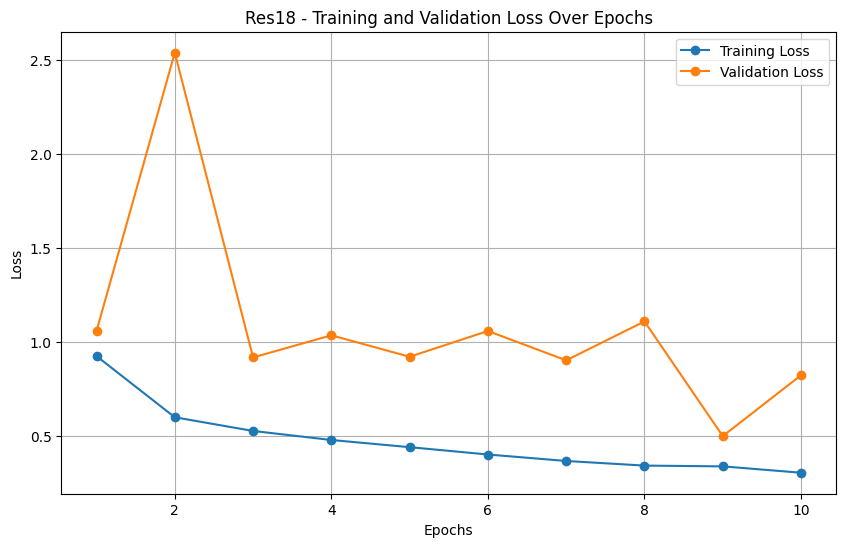

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_losses18, label='Training Loss', marker='o')
plt.plot(range(1, 11), val_losses18, label='Validation Loss', marker='o')
plt.title('Res18 - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 34-layer

In [ ]:
# train-34-layer
model34 = net34.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model34.parameters(), lr=0.001)

train_losses34 = []
val_losses34 = []

In [ ]:
start_time = time.time()
for epoch in range(10):
    model34.train()
    train_loss, correct, count = 0, 0, 0
    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model34(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(output, 1)
        count += labels.size(0)
        correct += preds.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_dl)
    train_losses34.append(avg_train_loss)
    train_accuracy = correct / count

    print(f"Epoch: {epoch+1} \tTrain accuracy: {train_accuracy:.4f} \tTrain Loss: {avg_train_loss:.4f}")

    # valid
    model34.eval()
    valid_loss, correct, count = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc="Validation", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            output = model34(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()

            _, preds = torch.max(output, 1)
            count += labels.size(0)
            correct += (preds == labels).sum().item()

    average_valid_loss = valid_loss / len(test_dl)
    val_losses34.append(average_valid_loss)
    val_accuracy = correct / count
    print(f"Validation accuracy: {val_accuracy:.4f}, Validation Loss: {average_valid_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total Training Time {elapsed_time:.2f} seconds")

Epoch 1: 100%|██████████| 110/110 [00:45<00:00,  2.41batch/s]


Epoch: 1 	Train accuracy: 0.5943 	Train Loss: 1.0443


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.85batch/s]


Validation accuracy: 0.6500, Validation Loss: 0.8750


Epoch 2: 100%|██████████| 110/110 [00:45<00:00,  2.40batch/s]


Epoch: 2 	Train accuracy: 0.7434 	Train Loss: 0.6877


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.85batch/s]


Validation accuracy: 0.5887, Validation Loss: 1.1724


Epoch 3: 100%|██████████| 110/110 [00:45<00:00,  2.40batch/s]


Epoch: 3 	Train accuracy: 0.7857 	Train Loss: 0.5848


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.77batch/s]


Validation accuracy: 0.6553, Validation Loss: 0.9679


Epoch 4: 100%|██████████| 110/110 [00:45<00:00,  2.39batch/s]


Epoch: 4 	Train accuracy: 0.8185 	Train Loss: 0.5059


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.79batch/s]


Validation accuracy: 0.7317, Validation Loss: 0.7494


Epoch 5: 100%|██████████| 110/110 [00:46<00:00,  2.37batch/s]


Epoch: 5 	Train accuracy: 0.8283 	Train Loss: 0.4793


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.85batch/s]


Validation accuracy: 0.6860, Validation Loss: 0.9404


Epoch 6: 100%|██████████| 110/110 [00:45<00:00,  2.39batch/s]


Epoch: 6 	Train accuracy: 0.8350 	Train Loss: 0.4594


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.79batch/s]


Validation accuracy: 0.7623, Validation Loss: 0.6818


Epoch 7: 100%|██████████| 110/110 [00:45<00:00,  2.40batch/s]


Epoch: 7 	Train accuracy: 0.8515 	Train Loss: 0.4191


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.92batch/s]


Validation accuracy: 0.7043, Validation Loss: 0.8748


Epoch 8: 100%|██████████| 110/110 [00:45<00:00,  2.40batch/s]


Epoch: 8 	Train accuracy: 0.8619 	Train Loss: 0.3907


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.85batch/s]


Validation accuracy: 0.8083, Validation Loss: 0.5514


Epoch 9: 100%|██████████| 110/110 [00:45<00:00,  2.41batch/s]


Epoch: 9 	Train accuracy: 0.8724 	Train Loss: 0.3681


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.83batch/s]


Validation accuracy: 0.8700, Validation Loss: 0.3668


Epoch 10: 100%|██████████| 110/110 [00:45<00:00,  2.44batch/s]


Epoch: 10 	Train accuracy: 0.8777 	Train Loss: 0.3454


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.84batch/s]

Validation accuracy: 0.8347, Validation Loss: 0.4558
Total Training Time 543.10 seconds


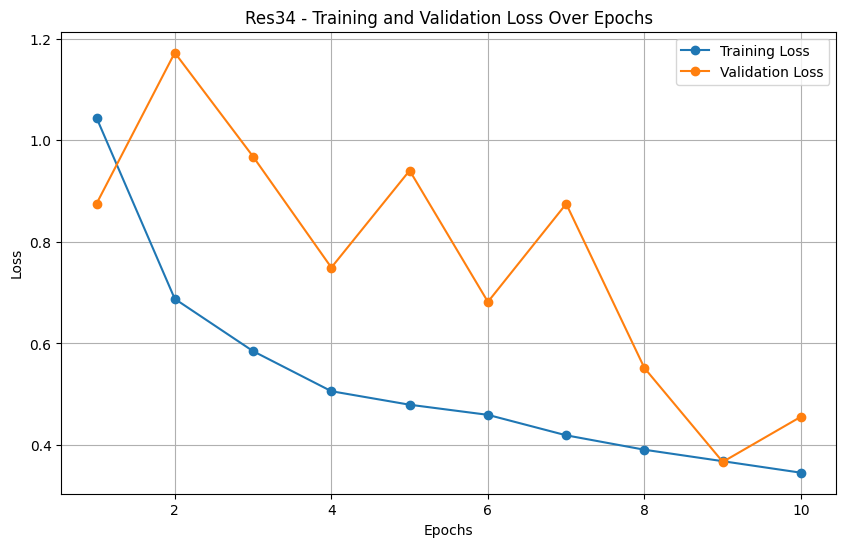

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_losses34, label='Training Loss', marker='o')
plt.plot(range(1, 11), val_losses34, label='Validation Loss', marker='o')
plt.title('Res34 - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 50-layer

In [ ]:
# train-50-layer
model50 = net50.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model50.parameters(), lr=0.001)

train_losses50 = []
val_losses50 = []

In [ ]:
start_time = time.time()
for epoch in range(10):
    model50.train()
    train_loss, correct, count = 0, 0, 0
    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model50(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(output, 1)
        count += labels.size(0)
        correct += preds.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_dl)
    train_losses50.append(avg_train_loss)
    train_accuracy = correct / count

    print(f"Epoch: {epoch+1} \tTrain accuracy: {train_accuracy:.4f} \tTrain Loss: {avg_train_loss:.4f}")

    # valid
    model50.eval()
    valid_loss, correct, count = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc="Validation", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            output = model50(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()

            _, preds = torch.max(output, 1)
            count += labels.size(0)
            correct += (preds == labels).sum().item()

    average_valid_loss = valid_loss / len(test_dl)
    val_losses50.append(average_valid_loss)
    val_accuracy = correct / count
    print(f"Validation accuracy: {val_accuracy:.4f}, Validation Loss: {average_valid_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total Training Time {elapsed_time:.2f} seconds")

Epoch 1: 100%|██████████| 110/110 [00:52<00:00,  2.08batch/s]


Epoch: 1 	Train accuracy: 0.5512 	Train Loss: 1.1717


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.67batch/s]


Validation accuracy: 0.5380, Validation Loss: 1.2178


Epoch 2: 100%|██████████| 110/110 [00:52<00:00,  2.08batch/s]


Epoch: 2 	Train accuracy: 0.7290 	Train Loss: 0.7237


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.68batch/s]


Validation accuracy: 0.6950, Validation Loss: 0.8042


Epoch 3: 100%|██████████| 110/110 [00:53<00:00,  2.04batch/s]


Epoch: 3 	Train accuracy: 0.7832 	Train Loss: 0.5948


Validation: 100%|██████████| 24/24 [00:09<00:00,  2.60batch/s]


Validation accuracy: 0.6933, Validation Loss: 0.8263


Epoch 4: 100%|██████████| 110/110 [00:52<00:00,  2.08batch/s]


Epoch: 4 	Train accuracy: 0.8040 	Train Loss: 0.5429


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.67batch/s]


Validation accuracy: 0.5717, Validation Loss: 1.5463


Epoch 5: 100%|██████████| 110/110 [00:53<00:00,  2.07batch/s]


Epoch: 5 	Train accuracy: 0.8179 	Train Loss: 0.4986


Validation: 100%|██████████| 24/24 [00:09<00:00,  2.56batch/s]


Validation accuracy: 0.7177, Validation Loss: 0.6994


Epoch 6: 100%|██████████| 110/110 [00:53<00:00,  2.05batch/s]


Epoch: 6 	Train accuracy: 0.8296 	Train Loss: 0.4856


Validation: 100%|██████████| 24/24 [00:09<00:00,  2.65batch/s]


Validation accuracy: 0.7430, Validation Loss: 0.7251


Epoch 7: 100%|██████████| 110/110 [00:52<00:00,  2.08batch/s]


Epoch: 7 	Train accuracy: 0.8477 	Train Loss: 0.4261


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.67batch/s]


Validation accuracy: 0.6383, Validation Loss: 1.2816


Epoch 8: 100%|██████████| 110/110 [00:52<00:00,  2.09batch/s]


Epoch: 8 	Train accuracy: 0.8577 	Train Loss: 0.3983


Validation: 100%|██████████| 24/24 [00:09<00:00,  2.64batch/s]


Validation accuracy: 0.5563, Validation Loss: 2.4217


Epoch 9: 100%|██████████| 110/110 [00:52<00:00,  2.10batch/s]


Epoch: 9 	Train accuracy: 0.8704 	Train Loss: 0.3684


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.75batch/s]


Validation accuracy: 0.5650, Validation Loss: 1.9854


Epoch 10: 100%|██████████| 110/110 [00:52<00:00,  2.10batch/s]


Epoch: 10 	Train accuracy: 0.8677 	Train Loss: 0.3620


Validation: 100%|██████████| 24/24 [00:08<00:00,  2.69batch/s]

Validation accuracy: 0.3933, Validation Loss: 3.4067
Total Training Time 620.37 seconds


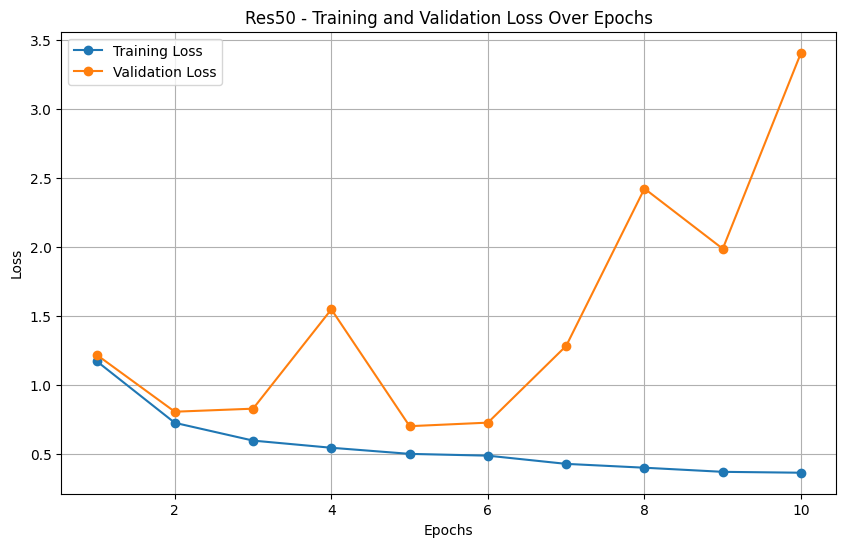

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_losses50, label='Training Loss', marker='o')
plt.plot(range(1, 11), val_losses50, label='Validation Loss', marker='o')
plt.title('Res50 - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Difference

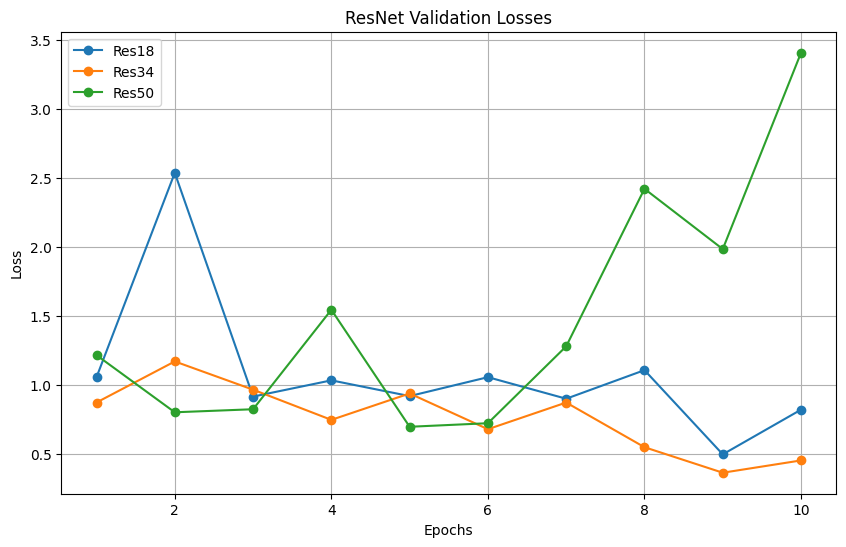

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), val_losses18, label='Res18', marker='o')
plt.plot(range(1, 11), val_losses34, label='Res34', marker='o')
plt.plot(range(1, 11), val_losses50, label='Res50', marker='o')
plt.title('ResNet Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Pred

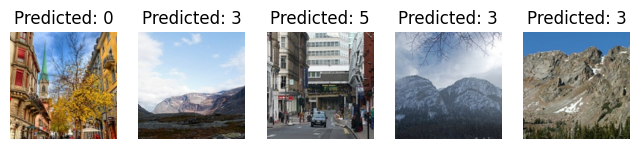

In [ ]:
model34.eval()

predictions = []

# 예측 데이터 로더를 순회하면서 예측 수행
with torch.no_grad():
    for batch in pred_dl:
        images = batch
        if isinstance(images, list):  # 또는 튜플로 확인: if isinstance(batch, tuple):
            images = images[0]
        images = images.to(device)
        outputs = model34(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())


# 예측 결과 시각화
def show_predictions(images, preds, n_images=5):
    plt.figure(figsize=(8, 8))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # 이미지 차원 변경: CxHxW -> HxWxC
        plt.title(f"Predicted: {preds[i]}")
        plt.axis("off")

# 예측 데이터 세트에서 이미지와 레이블 가져오기
images, _ = next(iter(pred_dl))
show_predictions(images, predictions)


In [ ]:
from PIL import Image
img = Image.open('./seg_pred/seg_pred/72.jpg')

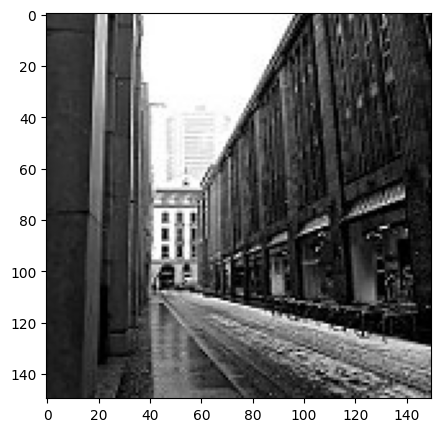

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(img)

In [ ]:
pimg = transform(img).unsqueeze(0).to(device)

prediction = model34(pimg)

_, tpredict = torch.max(prediction, 1)
classes={
    0:'Buildings',
    1:'Forest',
    2:'Glacier',
    3:'Mountain',
    4:'Sea',
    5:'Street'
}

print(tpredict)
print(classes[tpredict.item()])

tensor([5], device='cuda:0')
Street
